# Error Analysis

Let's check out what's our model doing wrong

In [1]:
%load_ext autoreload
%autoreload 2
import os
from datetime import datetime
import fire
import torch
import pandas as pd
from torchtext import data
import torch.nn as nn
from transformers import (
    AdamW, BertForSequenceClassification, BertTokenizer,
    get_constant_schedule_with_warmup
)

from offenseval.nn import (
    Tokenizer,
    train, evaluate, train_cycle, save_model, load_model, evaluate_dataset
)
from offenseval.datasets import datasets

pd.options.display.max_rows = 200
pd.options.display.max_colwidth = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, TEXT = load_model("../models/bert_cased.all.pt", device)
model.eval();

/home/jmperez/.local/share/virtualenvs/offenseval2020-HKdlw5Be/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'transformers.modeling_bert.BertSelfAttention' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Load the dataset as a `pd.DataFrame` (it could be done in the previous cell but well...)

In [2]:
from offenseval.nn.evaluation import evaluate
from offenseval.nn import EvaluationReport
from tqdm.auto import tqdm

dataset_path = datasets["english"]["test"]
report = evaluate_dataset(model, TEXT, dataset_path)

report


Loading dataset...
Building iterators


Acc: 91.46% Macro F1 0.899 (P 0.860 - N 0.939)

Create dataframe with predictions, probas, and so on

In [3]:
import csv

df = pd.read_table(dataset_path, index_col=0, 
                   quoting=csv.QUOTE_NONE)

df["label"] = df["subtask_a"] == 'OFF'

df["prob"] = report.probas.numpy()
df["pred"] = df["prob"] > 0.5


In [101]:
def calculate_confusion_matrix(df, label_col, pred_col):
    true_positives = df[df[label_col] & df[pred_col]].copy()
    true_negatives = df[~df[label_col] & ~df[pred_col]].copy()
    
    errors = df[df[label_col] != df[pred_col]]

    false_positives = errors[errors[pred_col]].copy()
    false_positives.sort_values(pred_col, ascending=False, inplace=True)

    false_negatives = errors[errors[label_col]].copy()
    false_negatives.sort_values(pred_col, ascending=True, inplace=True)

    return true_positives, true_negatives, false_positives, false_negatives

true_pos, true_neg, false_pos, false_neg = calculate_confusion_matrix(df, "label", "pred")

conf_matrix = pd.DataFrame([
    {"real":"not", "pred_not": len(true_neg), "pred_off": len(false_pos), },
    {"real":"off", "pred_not": len(false_neg), "pred_off": len(true_pos), },
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_neg)))
print("Falsos positivos: {}".format(len(false_pos)))

conf_matrix

Falsos negativos: 62
Falsos positivos: 270


,pred_not,pred_off
real,,
not,2537,270
off,62,1018


Plot it as a heatmap so it's more graphical

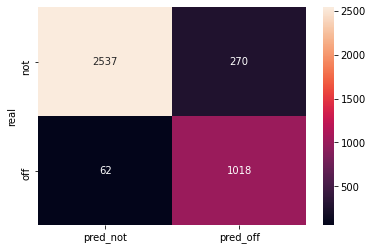

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt="")

plt.savefig("confusion-matrix.png")

Let's check out the false negatives. We have already ordered them by probability, so top rows are "worst" errors

## Captum

See [this issue in github for an explanation](https://github.com/pytorch/captum/issues/150)

First, let's retrieve the bert tokenizer in a very obscure way...

In [6]:
tokenizer_wrapper = TEXT.tokenize.__self__

bert_tokenizer = tokenizer_wrapper.bert_tokenizer

We need to use a wrapper

In [19]:
import torch
import torch.nn as nn

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig

from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import visualization
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer


def compute_bert_outputs(model_bert, embedding_output, attention_mask=None, head_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones(embedding_output.shape[0], embedding_output.shape[1]).to(embedding_output)

    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

    extended_attention_mask = extended_attention_mask.to(dtype=next(model_bert.parameters()).dtype) # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    if head_mask is not None:
        if head_mask.dim() == 1:
            head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            head_mask = head_mask.expand(model_bert.config.num_hidden_layers, -1, -1, -1, -1)
        elif head_mask.dim() == 2:
            head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # We can specify head_mask for each layer
        head_mask = head_mask.to(dtype=next(model_bert.parameters()).dtype) # switch to fload if need + fp16 compatibility
    else:
        head_mask = [None] * model_bert.config.num_hidden_layers

    encoder_outputs = model_bert.encoder(embedding_output,
                                         extended_attention_mask,
                                         head_mask=head_mask)
    sequence_output = encoder_outputs[0]
    pooled_output = model_bert.pooler(sequence_output)
    outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]  # add hidden_states and attentions if they are here
    return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)    



class BertModelWrapper(nn.Module):
    
    def __init__(self, model):
        super(BertModelWrapper, self).__init__()
        self.model = model
        
    def forward(self, embeddings):        
        outputs = compute_bert_outputs(self.model.bert, embeddings)
        pooled_output = outputs[1]
        pooled_output = self.model.dropout(pooled_output)
        logits = self.model.classifier(pooled_output)
        return torch.sigmoid(logits).unsqueeze(1)

bert_model_wrapper = BertModelWrapper(model)
ig = IntegratedGradients(bert_model_wrapper)


In [20]:


def interpret_sentence(model_wrapper, sentence, label, original_pred=None):
    model = model_wrapper.model
    model.eval()
    model.zero_grad()
    
    input_ids = torch.tensor([bert_tokenizer.encode(sentence, add_special_tokens=True)]).to(device)
    input_embedding = model.bert.embeddings(input_ids)
    
    
    baseline_ids = [bert_tokenizer.cls_token_id] 
    baseline_ids+= [bert_tokenizer.pad_token_id] * (len(input_ids[0]) - 2) 
    baseline_ids+= [bert_tokenizer.sep_token_id]
    baseline_ids = torch.tensor(baseline_ids).view(1, -1).to(device)

    baseline_embeddings = model.bert.embeddings(baseline_ids)
    # predict
        
    pred = model_wrapper(input_embedding).item()
    pred_ind = round(pred)

    # compute attributions and approximation delta using integrated gradients
    attributions_ig, delta = ig.attribute(input_embedding, baselines=baseline_embeddings,
                                          n_steps=50, return_convergence_delta=True)

    tokens = bert_tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy().tolist())
    return create_vis_record(attributions_ig, tokens, pred, pred_ind, label, delta.cpu().detach().numpy())
    
    
def create_vis_record(attributions, tokens, pred, pred_ind, label, delta):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    # import ipdb; ipdb.set_trace()
    # storing couple samples in an array for visualization purposes
    return visualization.VisualizationDataRecord(
        attributions,
        pred,
        pred_ind,
        label,
        "label",
        attributions.sum(),       
        tokens[:len(attributions)],
        delta
    )


In [72]:
visualization._get_color??

Signature: visualization._get_color(attr)
Docstring: <no docstring>
Source:   
def _get_color(attr):
    # clip values to prevent CSS errors (Values should be from [-1,1])
    attr = max(-1, min(1, attr))
    if attr > 0:
        hue = 120
        sat = 75
        lig = 100 - int(50 * attr)
    else:
        hue = 0
        sat = 75
        lig = 100 - int(-40 * attr)
    return "hsl({}, {}%, {}%)".format(hue, sat, lig)
File:      ~/projects/offenseval2020/captum/captum/attr/_utils/visualization.py
Type:      function


In [73]:
def _get_color(attr):
    """
    JMP: I change this function so red means "offensive"
    """
    # clip values to prevent CSS errors (Values should be from [-1,1])
    attr = -max(-1, min(1, attr))
    if attr > 0:
        hue = 120
        sat = 75
        lig = 100 - int(50 * attr)
    else:
        hue = 0
        sat = 75
        lig = 100 - int(-40 * attr)
    return "hsl({}, {}%, {}%)".format(hue, sat, lig)

def format_word_importances(words, importances):
    if importances is None or len(importances) == 0:
        return "<td></td>"
    assert len(words) <= len(importances)
    tags = ["<td>"]
    for word, importance in zip(words, importances[: len(words)]):
        if word.startswith("##"):
            word = word.strip("##")
            space = ""
        else:
            space = ' '
        color = _get_color(importance)
        unwrapped_tag = f'<mark style="background-color: {color}; opacity:1.0; \
                    line-height:1.75"><font color="black">{space}{word}</font></mark>'
        tags.append(unwrapped_tag)
    tags.append("</td>")
    return "".join(tags)

In [74]:
from IPython.core.display import display, HTML

def display_row(text):
    return f"<td> {text} </td>"

def display_class(val):
    if type(val) is str:
        return val
    else:
        return 'OFF' if int(val) == 1 else 'NOT'

def my_visualization(vis_records):
    dom = ["<table width: 100%>"]
    rows = [
        "<tr>"
        "<th>idx</th>"
        "<th>True Label</th>"
        "<th>Predicted Label</th>"
        #"<th>Predict Probability</th>"
        "<th>Word Importance</th>"
    ]
    for i, datarecord in enumerate(vis_records):
        rows.append(
            "".join(
                [
                    "<tr>",
                    f"<td>{i}</td>",
                    display_row(display_class(datarecord.true_class)),
                    display_row(display_class(datarecord.pred_class)),
                    #display_row(f"{datarecord.pred_prob:.2f}"),
                    format_word_importances(
                        datarecord.raw_input, datarecord.word_attributions
                    ),
                    "<tr>",
                ]
            )
        )

    dom.append("".join(rows))
    dom.append("</table>")
    display(HTML("".join(dom)))

In [24]:
from tqdm.auto import tqdm

false_pos_vis = []
false_neg_vis = []
true_pos_vis = []
true_neg_vis = []

"""
for _, row in tqdm(true_neg.iterrows(), total=len(true_neg)):
    true_neg_vis.append(
        interpret_sentence(bert_model_wrapper, sentence=row.tweet, label=row.subtask_a)
    )

for _, row in tqdm(true_pos.iterrows(), total=len(true_pos)):
    true_pos_vis.append(
        interpret_sentence(bert_model_wrapper, sentence=row.tweet, label=row.subtask_a)
    )
"""

for _, row in tqdm(false_pos.iterrows(), total=len(false_pos)):
    false_pos_vis.append(
        interpret_sentence(bert_model_wrapper, sentence=row.tweet, label=row.subtask_a)
    )
    
for _, row in tqdm(false_neg.iterrows(), total=len(false_neg)):
    false_neg_vis.append(
        interpret_sentence(bert_model_wrapper, sentence=row.tweet, label=row.subtask_a)
    )
    


In [75]:
from offenseval.nn.evaluation import predict_sentence

def predict(sentence):
    return predict_sentence(model, TEXT, sentence)


## False Pos

We can observe a lot of reliance in words (for instance `sucks, stupid`). However, it is not clear whether it should

In [76]:
predict("I really hate this")

0.992872953414917

In [77]:
predict("Terrorists!")

0.9977675676345825

In [78]:
predict("Disgusting!")

0.9980520009994507

In [79]:
predict("They call me a fascist")

0.9993888139724731

In [80]:
predict("This makes me feel ugly")

0.9908440709114075

Some others seems to be labelling errors, such as these:

[CLS] what border agent let those snakes on a plane ? did they have passports ? i bet you those snakes did not have any legal identification [SEP]

In [149]:
interesting_vis = false_pos_vis[3:7]

errors = [false_pos_vis[3], false_pos_vis[23]]

my_visualization(errors)

In [166]:
import html

for id, row in false_pos.iterrows():
    false_pos.loc[id, "tweet"] = html.unescape(row.tweet)

In [167]:

false_pos.iloc[[3, 23, 42, 46]]

,tweet,subtask_a,label,prob,pred
id,,,,,
A2344,what border agent let those snakes on a plane? did they have passports? i bet you those snakes did not have any legal identification,NOT,False,0.999450,True
A2705,@USER SHITTT do yall use the word??? i think here we conveniently use jarum suntikan,NOT,False,0.990684,True
A1997,Fuck knows how Coutinho fits in the team but I'll take him 😂 Please don't forget to buy a CB though for christ sake.,NOT,False,0.995052,True
A2044,It’s Me & Idgaf About Nothing 🤷🏻‍♀️Females with nigga mindsets are dangerous😂,NOT,False,0.989394,True


In [112]:
predict(false_pos.iloc[18].tweet)

0.9978183507919312

In [162]:
predict("@USER SHITTT")

0.9986640214920044

In [95]:

my_visualization(false_pos_vis)

Our classifier learns undesirable correlations from our data

For instance, the use of "Trump" in the sentence

In [47]:
predict("Trump")

0.8932088017463684

In [48]:
predict("Black gospel")

0.0005685754003934562

In [83]:
predict("They say it is disgusting")

0.9841445684432983

In [90]:
predict("Nice cat")

0.0005783441592939198

In [93]:
predict("I talk about a racist guy")

0.9993717074394226

## False Negative


In [170]:
error_negs = false_neg.iloc[[0, 8, 13, 14, 25, 28]]

error_negs


,tweet,subtask_a,label,prob,pred
id,,,,,
A18,Crazy that as we get older and go through certain shit you just want to keep it to yourself.,OFF,True,0.029142,False
A2333,@USER I don’t So far as you can recognize your Dad aa trash there’s no need to be talking to you,OFF,True,0.015773,False
A2756,"@USER Trump lied..and then coldly said it now appeared his building was the tallest in NYC. He's a sick, sick twist.",OFF,True,0.001872,False
A2782,Knew sis was a liar but I got soft anyways smh,OFF,True,0.003158,False
A3258,It’s crazy how people make excuses for them to walk out of a person’s life...,OFF,True,0.000711,False
A1893,"Be mild, pleasant and lenient with him who is harsh, gross, and strict with you; gradually he will turn to your behaviour.",OFF,True,0.425037,False


In [50]:
my_visualization(false_neg_vis)

In [36]:
false_neg.iloc[-4]

tweet        I need the nastiest sloppiness dick suck every😏💦🍆
subtask_a                                                  OFF
label                                                     True
prob                                                0.00321106
pred                                                     False
Name: A1543, dtype: object

In [65]:
text = false_neg.iloc[5].tweet[:120]
print(text)
bert_tokenizer.encode(text)
predict(text)

@USER @USER Donald Trump is to blame. He has been perfecting his racist tactics for decades, and now we see the result.


0.0030401190742850304